<h2>Bateman Equations for Multiple Decay</h2>

The inventory of each of four compounds was calculated assuming a multi-step reaction model. These calculations require several assumptions (Eganhouse and Pontolillo, 2008), as follows: (1) reactions and loss occur through first-order kinetics; (2) the only competing reaction is loss through unspecified physical processes discussed below; and (3) rates are constant over time and uniform throughout the sediment deposit (except the physical loss rate). The time-rate of change in $DDE$ inventory was determined by dechlorination to $DDMU$ and by possible losses through other processes. Likewise, the change in $DDMU$ inventory was determined losses from dechlorination to $DDNU$, gains from dechlorination of parent $DDE$, and losses by other processes. $DDNU$ inventory changes were analogous, with losses to an unspecified compound, gains from parent $DDMU$, and possible losses through other processes. The inventory of the final, unspecified product changes with gains from transformation of $DDMU$ and possible losses to other processes. The coupled differential equations (1) are

$\begin{matrix}
\frac{d{{C}_{DDE}}}{dt}=-{{k}_{1}}{{C}_{DDE}}-{{k}_{4}}{{C}_{DDE}}  \\
   \frac{d{{C}_{DDMU}}}{dt}=-{{k}_{2}}{{C}_{DDMU}}+{{k}_{1}}{{C}_{DDE}}-{{k}_{4}}{{C}_{DDMU}}  \\
   \frac{d{{C}_{DDNU}}}{dt}=-{{k}_{3}}{{C}_{DDNU}}+{{k}_{2}}{{C}_{DDMU}}-{{k}_{4}}{{C}_{DDNU}}  \\
   \frac{d{{C}_{UN}}}{dt}={{k}_{3}}{{C}_{DDNU}}-{{k}_{4}}{{C}_{UN}}  \\
\end{matrix}$

where the molar concentrations $C$ [$\mu$mol/kg dry sediment] of each compound and the transformation rate coefficients  [y-1] are labeled with subscripts. The losses to other processes accounted for physical removal of compounds from the sediment. Processes that have been suggested include direct desorption, resuspension and desorption, desorption into porewater and irrigation, and uptake by benthic deposit feeders. We have assumed that the combined rate coefficient for these processes applies equally to all four compounds. 


##### Import dependencies
LmFit (https://lmfit.github.io/lmfit-py/) "provides a high-level interface to non-linear optimization and curve fitting problems".

In [1]:
from scipy.integrate import odeint
from pylab import *
from lmfit import *
%matplotlib inline

##### The next cell contains key switches
* Identify which site to process
* Choose whether to adjust the inventories according to PCB anomolies. If selected `adjust_inventories` is `True` then computations are performed using adjusted invetories ${{C}_{i,\,adj}}$, where  $${{C}_{i,\,adj}}={{C}_{i}}\frac{\overline{PCB}}{{{\left\langle PCB \right\rangle }_{i}}}$$ where $C_i$ is the one of the measured inventory values, ${\left\langle PCB \right\rangle }_{i}$ is the average (over all congeners) of the PCB inventory at time $i$, and $\overline{PCB}$ is the time-average of ${\left\langle PCB \right\rangle }_{i}$

* Choose whether to include estimates of the std. deviations $\sigma_i$ of inventories in the objective function. The objective function returns an array of length $N$ for each observation $data_i$ and associated modeled result $model_i$ and is calculated as $$\frac{{{\left( mode{{l}_{i}}-dat{{a}_{i}} \right)}^{2}}}{\sigma _{i}^{2}}$$ If `use_eps` is `False`, $\sigma = 1$.

In [30]:
# Pick one of the two sites
#site = 'Site 3C'
site = 'Site 6C'

# Adjust using PCBs?
adjust_inventories=False
# Use std. deviations in chi-square calculation?
use_eps=True

# These strings are used to build filenames for the output figures
itext = '_'
if adjust_inventories:
    itext = "_adj_"
etext = '_'
if use_eps:
    etext = "_eps_"

##### These data are from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 'Inventories for C.Sherwood 12-16-2016.xlsx'

In [12]:
# Load data for the selected site
if site == 'Site 3C':
    A=np.array([\
    [1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076],\
    [1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064],\
    [2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050],\
    [2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085],\
    [2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079]])
if site == 'Site 6C':
    A=np.array([\
    [1992.52,3.07,0.67,0.026,0.0182,0.0119,0.0152],\
    [2003.58,2.75,0.87,0.072,0.0177,0.0122,0.0158],\
    [2009.23,2.37,0.75,0.095,0.0172,0.0095,0.0134],\
    [2010.31,1.16,0.43,0.046,0.0079,0.0054,0.0065]])

t = A[:,0]
DDE=A[:,1]
DDMU=A[:,2]
DDNU=A[:,3]

print("Data from {0} with shape {1}".format(site,A.shape))
print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in A]))

Data from Site 6C with shape (4L, 7L)
1992.5200  3.0700  0.6700  0.0260  0.0182  0.0119  0.0152  
2003.5800  2.7500  0.8700  0.0720  0.0177  0.0122  0.0158  
2009.2300  2.3700  0.7500  0.0950  0.0172  0.0095  0.0134  
2010.3100  1.1600  0.4300  0.0460  0.0079  0.0054  0.0065  


##### Stand-alone example of integrating the coupled ODEs

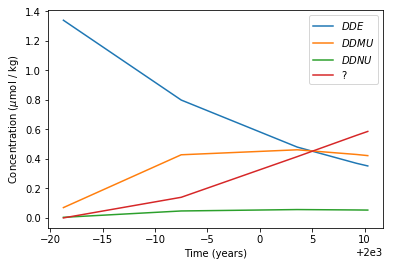

In [13]:
# In my previous notebook decay rates were global variables
# so they can be seen inside the function. That is not necessary
# if you use the args = (k,) syntax
k = np.array([.046, .056, .46, .0])

# define a function to represent coupled ordinary differential eqns.
# this version allows for a fourth loss term that applies to all compounds
def dcdt(c, t, k):
    dfdt = np.zeros(4)
    dfdt[0] = c[0]* -k[0] - c[0]*k[3]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0] - c[1]*k[3] 
    dfdt[2] = c[2]* -k[2] + c[1]*k[1] - c[2]*k[3]
    dfdt[3] =               c[2]*k[2] - c[3]*k[3]
    return dfdt
    
# intial concentration for four constituents
C0e = np.array([1.34, .07, .004, 0.])

# time array
# te = linspace(0.0,100.,50)

# or, for discrete times that match Site 6C measurements:
te = np.array(( 1981.27, 1992.51, 2003.58, 2009.23, 2010.31 ))

# Use the 
Ce = odeint(dcdt,C0e,te, args = (k,))

fig = plt.figure()
plt.plot(te,Ce[:,0],label='$DDE$')
plt.plot(te,Ce[:,1],label='$DDMU$')
plt.plot(te,Ce[:,2],label='$DDNU$')
plt.plot(te,Ce[:,3],label='?')
plt.xlabel('Time (years)')
plt.ylabel('Concentration ($\mu$mol / kg)')
plt.legend(loc='upper right')

##### Define the model
This is a simpler version with no global decay rate, and no fourth-generation product. It is a coupled set of ordinary differential equations that, in the model, are integrated with the `scipy.odeint` function.

In [14]:
# Version of ODE with three-generation transformation and only three transfer terms
def dcdt3(c, t, k):
    dfdt = np.zeros(3)
    dfdt[0] = c[0]* -k[0]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0]
    dfdt[2] = c[2]* -k[2] + c[1]*k[1]
    return dfdt

##### Define the objective functions to minimize
These functions return the quantity that lmfit will try to minimize. They are returned as vectors of length $N$, the number of data points (and corresponding model estimates). The RMS of this vector is the chi-square goodness of fit.

In [15]:
# Objective function to minimize, fit through origin, estimate decay rate
def residual(params, t, data, eps_data):
    C0 = data[0]
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)/eps_data

# Objective function to minimize, estimate origin and decay rate
def residual2(params, t, data, eps_data):
    C0 = params['init_conc']
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)/eps_data

# Objective function using ODE for three-generation transformation 
def residual3(params, t, data, eps_data):
    # Data is passed as a vector
    # Index on length of time array to find intitial concentrations
    nt = t.size
    k = np.array((params['k1'],params['k2'],params['k3']))
    C0 = np.array((data[0],data[nt],data[2*nt]))
    C = odeint(dcdt3,C0,t, args = (k,))
    model = np.concatenate((C[:,0],C[:,1],C[:,2]))
    return (data-model)/eps_data
    

In [16]:
# guess at std. error in measurements per conv. with R.E.
stde_DDE  = 0.05          #RE suggests 0.05
stde_DDMU = 0.09          #RE suggested 0.1
stde_DDNU = 0.1          #RE suggested 0.1
stde_PCB  = 0.05          # std. error of measurements is around 0.2
eps_DDE  = stde_DDE*DDE  
eps_DDMU = stde_DDMU*DDMU #RE suggested 0.1
eps_DDNU = stde_DDNU*DDNU #RE suggested 0.2

# calculate adjustment according to mean of all PCBs inventory
pcbm = A[:,4:6].mean(axis=1)
adj = pcbm.mean()/pcbm
print("Average PCB inventories")
print(pcbm)
print("Adjustment factor")
print(adj)
print("eps_adj")
eps_adj = stde_PCB*adj
print(eps_adj)
print("Std. deviation of normalized PCB inventories: {0:5.3f}\n".format(adj.std()))

# Data for DDE loss only
data = DDE
eps_data = ones_like(data)
if use_eps:
    eps_data = eps_DDE

print('DDE data: ')
print(data)
print('eps_data: ')
print(eps_data)

# Adjust inventories according to PCB inventories?
if(adjust_inventories):
    data = data*adj
    eps_data = ones_like(data)
    if use_eps:
        eps_data = np.sqrt( eps_DDE**2. + eps_adj**2. )
    
    print('Adjusted DDE data: ')
    print(data)
    print('Adjusted eps_data: ')
    print(eps_data)

params = Parameters()
# Note that this does not work if there are extra parameters
#params.add('init_conc',value = 1., min = 0., max= 5.)
params.add('decay_rate',value = 0.4, min =0., max = 1.)
out = minimize(residual, params, method='leastsq', args=(t,data,eps_data))

# Get the fitted rates
k1f=out.params['decay_rate'].value
k1e = out.params['decay_rate'].stderr

# Get fit metrics
chis = out.chisqr
chir = out.redchi

Average PCB inventories
[ 0.01505  0.01495  0.01335  0.00665]
Adjustment factor
[ 0.83056478  0.8361204   0.93632959  1.87969925]
eps_adj
[ 0.04152824  0.04180602  0.04681648  0.09398496]
Std. deviation of normalized PCB inventories: 0.440

DDE data: 
[ 3.07  2.75  2.37  1.16]
eps_data: 
[ 0.1535  0.1375  0.1185  0.058 ]



Estimate decay rate with fit through origin
 Site 6C
  Using estimates of std. errors
[[Fit Statistics]]
    # function evals   = 16
    # data points      = 4
    # variables        = 1
    chi-square         = 112.463
    reduced chi-square = 37.488
    Akaike info crit   = 15.345
    Bayesian info crit = 14.732
[[Variables]]
    decay_rate:   0.04128435 +/- 0.011660 (28.24%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)


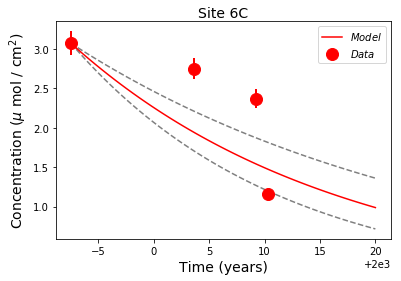

In [17]:
# Run the model with those fits, plus or minus
tm = linspace(t[0],2020.,50)

# or, for discrete times that match measurements:
#t = np.array(( 1981.27, 1992.51, 2003.58, 2009.23, 2010.31 ))

# Use the 
Cm = data[0]*exp(-k1f*(tm-tm[0]))
Cl = data[0]*exp(-(k1f+k1e)*(tm-tm[0]))
Ch = data[0]*exp(-(k1f-k1e)*(tm-tm[0]))

fig = plt.figure()
plt.plot(tm,Cl,'--',color='gray')
plt.plot(tm,Ch,'--',color='gray')
plt.plot(tm,Cm,'-', color='red',label='$Model$')
h=plt.plot(t,data,'o',color='red',markersize=12,linestyle='None',label='$Data$')
plt.setp(h,linestyle='None')
plt.errorbar(t,data, yerr=eps_DDE,color='red',elinewidth=2,linestyle='None')
plt.xlabel(r'Time (years)', fontsize=14)
plt.ylabel(r'Concentration ($\mu$ mol / cm$^2$)',fontsize=14)
plt.legend(loc='upper right')
plt.title(site,fontsize=14)

print('\nEstimate decay rate with fit through origin')
print(" {}".format(site))
if(adjust_inventories):
    print("  Inventories adjusted by mean PCB inventories")
if(use_eps):
    print("  Using estimates of std. errors")
report_fit(out)

In [18]:
print('\nEstimate decay rate and initial conc')
print(" {}".format(site))
if(adjust_inventories):
    print("  Inventories adjusted by mean PCB inventories")
if(use_eps):
    print("  Using estimates of std. errors")
params = Parameters()
params.add('init_conc',value = 1., min = 0., max= 5.)
params.add('decay_rate',value = 0.4, min =0., max = 1.)
out = minimize(residual2, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)


Estimate decay rate and initial conc
 Site 6C
  Using estimates of std. errors
[[Fit Statistics]]
    # function evals   = 29
    # data points      = 4
    # variables        = 2
    chi-square         = 109.445
    reduced chi-square = 54.722
    Akaike info crit   = 17.237
    Bayesian info crit = 16.009
[[Variables]]
    init_conc:    3.32203925 +/- 1.104283 (33.24%) (init= 1)
    decay_rate:   0.04588673 +/- 0.024424 (53.23%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)
    C(init_conc, decay_rate)     =  0.817 


data
[ 3.07   2.75   2.37   1.16   0.67   0.87   0.75   0.43   0.026  0.072
  0.095  0.046]
eps_data
[ 0.1535  0.1375  0.1185  0.058   0.0603  0.0783  0.0675  0.0387  0.0026
  0.0072  0.0095  0.0046]
('residual3 shape:', (12L,))
sumsq resdisuals: 59.4926037793

Full Monty - Fit to DDE, DDMU, and DDNU
 Site 6C
  Using estimates of std. errors
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 12
    # variables        = 3
    chi-square         = 155.881
    reduced chi-square = 17.320
    Akaike info crit   = 36.770
    Bayesian info crit = 38.225
[[Variables]]
    k1:   0.04191350 +/- 0.007968 (19.01%) (init= 0.4)
    k2:   0.14739762 +/- 0.035143 (23.84%) (init= 0.4)
    k3:   1.43912614 +/- 0.378779 (26.32%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k1, k2)                    =  0.376 
    C(k1, k3)                    =  0.376 
    C(k2, k3)                    =  0.159 
4
(4L,)
(4L,)
(12L,)


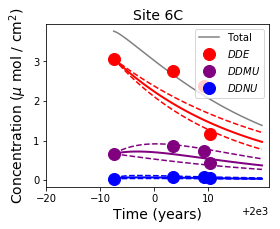

In [35]:
# Put data for all compounds in a single vector
nt = t.size
data = np.concatenate((DDE,DDMU,DDNU))
eps_data = np.ones_like(data)
if(use_eps):
    eps_data = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))

if(adjust_inventories):
    # calculate adjustment according to mean of all PCBs inventory
    # this is redone here because size of adj will change here
    pcbm = A[:,4:6].mean(axis=1)
    adjv = pcbm.mean()/pcbm
    adj = np.concatenate( (adjv, adjv, adjv) )
    data = data*adj
    eps_adj =  np.ones_like(data)
    if use_eps:
        eps_adjv = stde_PCB*adjv
        eps_adj = np.concatenate((eps_adjv,eps_adjv,eps_adjv))
        eps_data = np.sqrt( (eps_data**2. + eps_adj**2. ) )

print('data')
print(data)
print('eps_data')
print(eps_data)

params = Parameters()
params.add('k1',value = 0.4, min =0., max = 1.)
params.add('k2',value = 0.4, min =0., max = 1.)
params.add('k3',value = 0.4, min =0., max = 1.5)

# Test the ODE solver
k = np.array((params['k1'],params['k2'],params['k3']))
C0 = np.array((data[0],data[nt],data[2*nt]))
C = odeint(dcdt3,C0,t, args = (k,))
model = np.concatenate((C[:,0],C[:,1],C[:,2]))

# Test the objective function outside
res = residual3(params, t, data, eps_data)
print("residual3 shape:",shape(res))
print("sumsq resdisuals: {:}".format( np.sqrt(sum(res**2))))

# Optimize the parameters using least-squares fit
out = minimize(residual3, params, method='leastsq', args=(t,data,eps_data))

# Get the fitted rates
kf = np.zeros((3,))
kf[0]=out.params['k1'].value
kf[1]=out.params['k2'].value
kf[2]=out.params['k3'].value
ke = np.zeros((3,))
ke[0] = out.params['k1'].stderr
ke[1] = out.params['k2'].stderr
ke[2] = out.params['k3'].stderr

# Get fit metrics
chis = out.chisqr
chir = out.redchi

# Run the ODE solver with best-fit results
tm = linspace(t[0],2020.,50)
C0 = np.array((data[0],data[nt],data[2*nt]))
Cm = odeint(dcdt3,C0,tm, args = (kf,))

# now run it for all of the cases with +/- uncertainty
kmult = np.array((0.,1.,-1.))
kep = np.zeros((27,3))
Cc = np.zeros_like(Cm)
Cmax = np.zeros_like(Cm)
Cmin = np.zeros_like(Cm)
C1 = np.zeros((27,50))
C2 = np.zeros((27,50))
C3 = np.zeros((27,50))
n =0
for k in np.arange(3):
    for j in np.arange(3):
        for i in np.arange(3):
            kep[n][0]=kf[0]+ke[0]*kmult[k]
            kep[n][1]=kf[1]+ke[1]*kmult[i]
            kep[n][2]=kf[2]+ke[2]*kmult[j]
            C0 = np.array((data[0],data[nt],data[2*nt]))
            Cc = odeint(dcdt3,C0,tm, args = (kep[n,:],))
            C1[n,:] = Cc[:,0]
            C2[n,:] = Cc[:,1]
            C3[n,:] = Cc[:,2]
            n=n+1

Cmax[:,0] = np.amax(C1,axis=0)
Cmin[:,0] = np.amin(C1,axis=0)
Cmax[:,1] = np.amax(C2,axis=0)
Cmin[:,1] = np.amin(C2,axis=0)
Cmax[:,2] = np.amax(C3,axis=0)
Cmin[:,2] = np.amin(C3,axis=0)

print('\nFull Monty - Fit to DDE, DDMU, and DDNU')
print(" {}".format(site))
if(adjust_inventories):
    print("  Inventories adjusted by mean PCB inventories")
if(use_eps):
    print("  Using estimates of std. errors")
report_fit(out)

print(nt)
print(shape(t))
print(shape(data[0:nt]))
print(shape(eps_data))


fig = plt.figure(figsize=(4,3))
plt.plot(tm,Cm[:,0]+Cm[:,1]+Cm[:,2],'-',color='gray',label="Total")
plt.plot(tm,Cmax[:,2],'--',color='blue')
plt.plot(tm,Cmin[:,2],'--',color='blue')
plt.plot(tm,Cmax[:,1],'--',color='purple')
plt.plot(tm,Cmin[:,1],'--',color='purple')
plt.plot(tm,Cmax[:,0],'--',color='red')
plt.plot(tm,Cmin[:,0],'--',color='red')
plt.plot(tm,Cm[:,2],'-', color='blue',linewidth=2)
plt.plot(tm,Cm[:,1],'-', color='purple',linewidth=2)
plt.plot(tm,Cm[:,0],'-', color='red',linewidth=2)
plt.plot(t,data[0:nt],'o',color='red',markersize=12,linestyle='None',label='$DDE$')
plt.plot(t,data[nt:2*nt],'o',color='purple',markersize=12,linestyle='None',label='$DDMU$')
plt.plot(t,data[2*nt:3*nt],'o',color='blue',markersize=12,linestyle='None',label='$DDNU$')
plt.setp(h,linestyle='None')
plt.errorbar(t,data[0:nt], yerr=eps_data[0:nt],color='red',elinewidth=2,linestyle='None')
plt.errorbar(t,data[nt:2*nt], yerr=eps_data[nt:2*nt],color='purple',elinewidth=2,linestyle='None')
plt.errorbar(t,data[2*nt:3*nt], yerr=eps_data[2*nt:3*nt],color='blue',elinewidth=2,linestyle='None')
plt.xticks(np.arange(1980,2020,10))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Testing'
ax.set_xticklabels(labels)
plt.xlabel(r'Time (years)', fontsize=14)
if(site=='Site 6C'):
    plt.ylabel(r'Concentration ($\mu$ mol / cm$^2$)',fontsize=14)
plt.legend(loc='upper right')
plt.title(site,fontsize=14)
figname = site+itext+etext+"DDE_DDMU_DDNU.png"
plt.savefig(figname, bbox_inches='tight')